In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from clickhouse_driver import Client

## Download files

In [2]:
members = pd.read_csv('../CSV/VK_Fishing_members')
city = pd.read_csv('../CSV/VK_Fishing_city')

members['last_seen'] = pd.to_datetime(members['last_seen'])

## Clickhouse

In [3]:
# соединение с Clickhouse
client = Client('localhost', 9000)

### Create

In [4]:
# создание таблицы для пользователей
create_table_vk = '''
CREATE TABLE IF NOT EXISTS vk_fishing (
    user_id_vk UInt64
    ,fullname String
    ,name String
    ,last_seen DateTime
    ,contacts String
    ,friends_count UInt32
    ,town Int64
    ,age Int32
    ,PRIMARY KEY (user_id_vk)
) ENGINE = MergeTree()
ORDER BY user_id_vk;'''

client.execute(create_table_vk)

[]

In [5]:
# создание таблицы для городов
create_table_city = '''
CREATE TABLE IF NOT EXISTS city (
    city_id Int64
    ,name String
    ,PRIMARY KEY(city_id)
) ENGINE = MergeTree()
ORDER BY city_id;'''

client.execute(create_table_city)

[]

### Insert

In [6]:
# внесение данных о пользователях
insert_into_members = (f'INSERT INTO vk_fishing VALUES')
values_members = ",".join(["(" + ",".join("'" + str(val) + "'" if val is not None else "NULL" for val in row) + ")" for row in members.values])

client.execute(insert_into_members + " " + values_members)

[]

In [7]:
# внесение данных о городах
insert_into_city = (f'INSERT INTO city VALUES')
values_city = ",".join(["(" + ",".join("'" + str(val) + "'" for val in row) + ")" for row in city.values])

client.execute(insert_into_city + " " + values_city)

[]

### Select

### Топ - 5 самых популярных имен (Fullname)

In [8]:
select_names = '''SELECT fullname
                    ,count(fullname) 
                FROM vk_fishing vf
                GROUP BY fullname
                ORDER BY count(*) DESC
                LIMIT 5;'''

result_names = client.execute(select_names)
names = pd.DataFrame(result_names, columns=['Name', 'Count'])
fig = px.pie(names=names['Name'], values=names['Count'], title='Топ 5 популярных имён(Fullname)')
fig.show()

### Топ - 5 самых популярных имен (Name)

In [9]:
select_names = '''SELECT name
                    ,count(name) 
                FROM vk_fishing vf
                GROUP BY name
                ORDER BY count(*) DESC
                LIMIT 5;'''

result_names = client.execute(select_names)
names = pd.DataFrame(result_names, columns=['Name', 'Count'])
fig = px.pie(names=names['Name'], values=names['Count'], title='Топ 5 популярных имён (Name)')
fig.show()

### Диаграммы рассеяния - Сколько лет (Кол-во друзей)

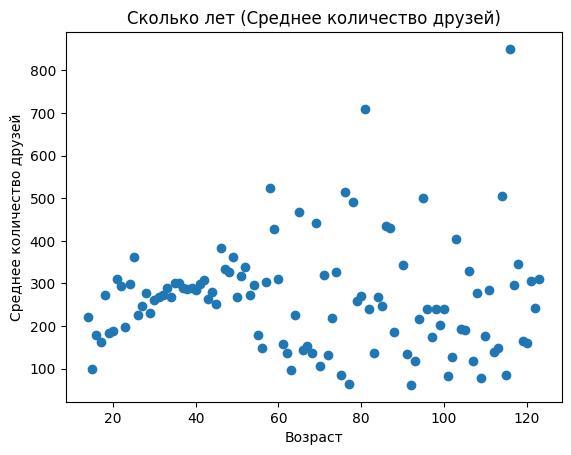

In [10]:
select_friends = '''SELECT age 
                    ,round(avg(friends_count)) AS avg_friends
                FROM vk_fishing
                WHERE age <> 0
                GROUP BY age
                ORDER BY age;'''

result_friends = client.execute(select_friends)
friends = pd.DataFrame(result_friends, columns=['age', 'avg_friends'])
friends['avg_friends'] = friends['avg_friends'].astype(int)
plt.scatter(friends['age'], friends['avg_friends'])


plt.title('Сколько лет (Среднее количество друзей)')
plt.xlabel('Возраст')
plt.ylabel('Среднее количество друзей');

### Выдать топ-3 города, в которых среднее кол-во друзей участников группы самое наибольшее

In [11]:
select_avg_cities = '''SELECT c.name AS City
                            ,count(c.name) AS repetitions_of_city
                            ,sum(friends_count) AS Sum_Friends
                            ,round(Sum_Friends / count(c.name)) AS AVG_Friends 
                        FROM city c JOIN vk_fishing vf 
                        ON vf.town = c.city_id
                        WHERE vf.town <> -1
                        GROUP BY City
                        ORDER BY AVG_Friends DESC
                        LIMIT 3;'''

result_avg_cities = client.execute(select_avg_cities)


print('Топ-3 города, в которых среднее кол-во друзей участников группы самое наибольшее:')
for row in result_avg_cities:
    print(row)

Топ-3 города, в которых среднее кол-во друзей участников группы самое наибольшее:
('Западное Кончезеро', 4, 38892, 9723.0)
('Судромская', 4, 37144, 9286.0)
('Ko Samui', 4, 35592, 8898.0)


### Какой город самый часто встречаемый у участников этой группы

In [12]:
select_top_city = '''SELECT c.name AS City
                        ,count(c.name) AS repetitions_of_city
                    FROM vk_fishing vf 
                    JOIN city c ON vf.town = c.city_id
                    WHERE vf.town <> -1
                    GROUP BY City
                    ORDER BY repetitions_of_city DESC
                    LIMIT 1;'''

result_top_city = client.execute(select_top_city)


print('Cамый часто встречаемый город:')
for row in result_top_city:
    print(row)

Cамый часто встречаемый город:
('Москва', 34876)


In [13]:
client.disconnect()